In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import sys
customized_path = "/content/drive/Shareddrives/Urban Computing Project/"
sys.path.append(customized_path)

# Install Dependencies

In [3]:
# pip install sktime

     |████████████████████████████████| 6.2 MB 23.4 MB/s 
     |████████████████████████████████| 9.8 MB 30.1 MB/s 
     |████████████████████████████████| 3.3 MB 50.0 MB/s 
     |████████████████████████████████| 14.9 MB 58.8 MB/s 
     |████████████████████████████████| 26.3 MB 1.9 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: numba
    Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 

In [1]:
# pip install pmdarima

     |████████████████████████████████| 1.4 MB 23.5 MB/s 
  Using cached statsmodels-0.13.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.8 MB)
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sktime 0.9.0 requires statsmodels<=0.12.1, but you have statsmodels 0.13.1 which is incompatible.


# Imports

In [45]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error,mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose      
from pmdarima import auto_arima   
from statsmodels.tools.eval_measures import rmse, meanabs
from fbprophet import Prophet                         
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# Data Processing

In [6]:
df = pd.read_csv('/content/drive/Shareddrives/Urban Computing Project/datasets/junbusfinal.csv', index_col=0, parse_dates=True)

In [7]:
df.head()

,RecordedAtTime,zone,late,time_difference
0,2017-06-01 00:00:00,Allerton/Pelham Gardens,4,-71.000000
1,2017-06-01 00:00:00,Alphabet City,2,-143.500000
2,2017-06-01 00:00:00,Arrochar/Fort Wadsworth,2,-267.000000
3,2017-06-01 00:00:00,Auburndale,3,30.333333
4,2017-06-01 00:00:00,Bath Beach,2,-17.500000


In [9]:
df.shape

(778981, 4)

In [10]:
df.dtypes

RecordedAtTime      object
zone                object
late                 int64
time_difference    float64
dtype: object

In [11]:
df.rename(columns = {'RecordedAtTime':'time'}, inplace = True)

In [13]:
df['time'] = pd.to_datetime(df['time'], errors = 'coerce')

In [14]:
df['day_of_week'] = df['time'].dt.day
df['date'] = df['time'].dt.date
df['hour'] = df['time'].dt.hour

In [15]:
df.head()

,time,zone,late,time_difference,day_of_week,date,hour
0,2017-06-01,Allerton/Pelham Gardens,4,-71.000000,1,2017-06-01,0
1,2017-06-01,Alphabet City,2,-143.500000,1,2017-06-01,0
2,2017-06-01,Arrochar/Fort Wadsworth,2,-267.000000,1,2017-06-01,0
3,2017-06-01,Auburndale,3,30.333333,1,2017-06-01,0
4,2017-06-01,Bath Beach,2,-17.500000,1,2017-06-01,0


In [16]:
df.dtypes

time               datetime64[ns]
zone                       object
late                        int64
time_difference           float64
day_of_week                 int64
date                       object
hour                        int64
dtype: object

In [17]:
df_z1 = df[df['zone'] == 'Alphabet City']

In [18]:
df_z1 = df_z1[df_z1['hour'] == 8]

In [19]:
df_z1.head()

,time,zone,late,time_difference,day_of_week,date,hour
6989,2017-06-01 08:00:00,Alphabet City,7,260.857143,1,2017-06-01,8
7206,2017-06-01 08:10:00,Alphabet City,5,-65.000000,1,2017-06-01,8
7426,2017-06-01 08:20:00,Alphabet City,3,-245.666667,1,2017-06-01,8
7646,2017-06-01 08:30:00,Alphabet City,6,30.333333,1,2017-06-01,8
7866,2017-06-01 08:40:00,Alphabet City,5,26.200000,1,2017-06-01,8


In [20]:
dt_srs = df_z1.set_index(['date']).drop(['time', 'zone', 'day_of_week','hour' ], axis=1)

In [21]:
dt_srs

,late,time_difference
date,,
2017-06-01,7,260.857143
2017-06-01,5,-65.000000
2017-06-01,3,-245.666667
2017-06-01,6,30.333333
2017-06-01,5,26.200000
...,...,...
2017-06-30,11,-110.363636
2017-06-30,11,-335.363636
2017-06-30,12,-86.166667


In [22]:
df_sum = dt_srs.groupby(['date']).sum()

In [23]:
df_sum.head()

,late,time_difference
date,,
2017-06-01,28,-147.776190
2017-06-02,83,-1631.960256
2017-06-03,27,-2344.155556
2017-06-04,28,-1439.083333
2017-06-05,76,-1574.059341


## Data Visualization

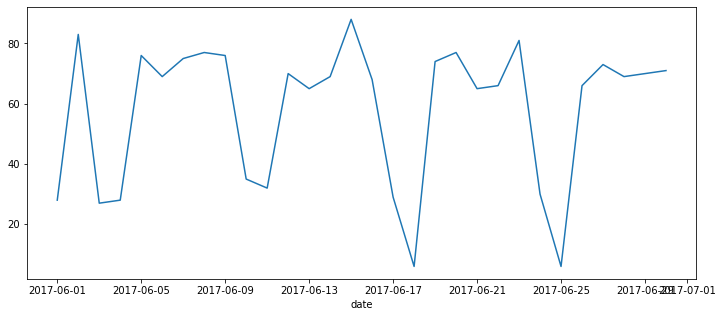

In [24]:
df_sum['late'].plot(figsize=(12, 5))

In [25]:
df_sum = df_sum.drop(['time_difference'], axis=1)

# ADF TEST

In [26]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [27]:
adf_test(df_sum['late'])

Augmented Dickey-Fuller Test: 
ADF test statistic      -1.257773
p-value                  0.648263
# lags used              6.000000
# observations          23.000000
critical value (1%)     -3.752928
critical value (5%)     -2.998500
critical value (10%)    -2.638967
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [32]:
train_data = df_sum.iloc[:23]
test_data = df_sum.iloc[23:]

# Holts-Winter

In [ ]:
fitted_model = ExponentialSmoothing(train_data['late'],trend='mul',seasonal='mul',seasonal_periods=4).fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [ ]:
test_predictions = fitted_model.forecast(6).rename('HW Forecast')

In [ ]:
test_predictions

2017-06-25    10.083668
2017-06-26     9.770066
2017-06-27    11.298662
2017-06-28    10.402397
2017-06-29    10.285199
2017-06-30     9.965329
Freq: D, Name: HW Forecast, dtype: float64

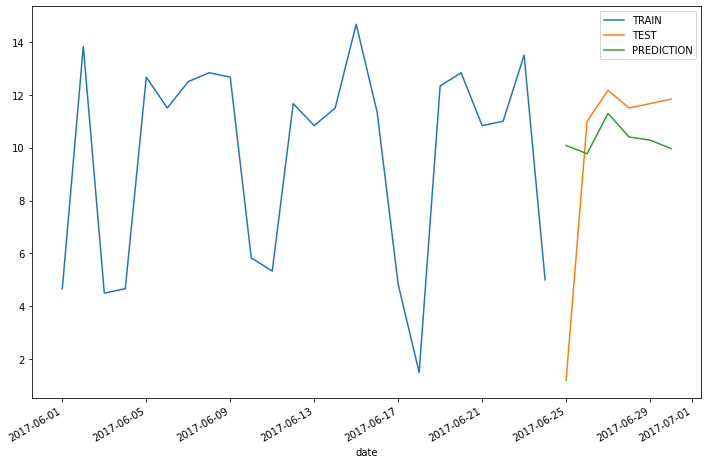

In [ ]:
train_data['late'].plot(legend=True,label='TRAIN')
test_data['late'].plot(legend=True,label='TEST',figsize=(12,8))
test_predictions.plot(legend=True,label='PREDICTION');

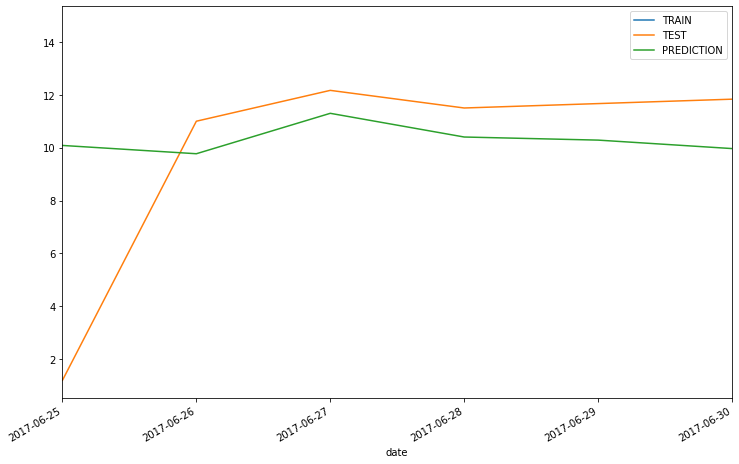

In [ ]:
train_data['late'].plot(legend=True,label='TRAIN')
test_data['late'].plot(legend=True,label='TEST',figsize=(12,8))
test_predictions.plot(legend=True,label='PREDICTION',xlim=['2017-06-25','2017-06-30']);

In [ ]:
test_data.describe()

,late
count,6.000000
mean,9.894444
std,4.276833
min,1.200000
25%,11.125000
50%,11.583333
75%,11.791667
max,12.166667


In [ ]:
mean_squared_error(test_data,test_predictions)

14.631392886678123

In [ ]:
np.sqrt(mean_squared_error(test_data,test_predictions))

3.8251003760265068

In [ ]:
mean_absolute_error(test_data,test_predictions)

2.5547802602763467

# AR

In [ ]:
model = AutoReg(train_data['late'], lags = 2, seasonal=True, period = 3)
AR1fit = model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [ ]:
start=len(train_data)
end=len(train_data)+len(test_data)-1
predictions1 = AR1fit.predict(start=start, end=end, dynamic=False).rename('AR(1) Predictions')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/deterministic.py:157: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and NumericIndex with a unit increment support extending. The index is set will contain the position relative to the data length.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/deterministic.py:157: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and NumericIndex with a unit increment support extending. The index is set will contain the position relative to the data length.
  UserWarning,


In [ ]:
predictions1

2017-06-25     7.617381
2017-06-26    11.607163
2017-06-27     9.750514
2017-06-28     9.442740
2017-06-29    10.370051
2017-06-30     8.803638
Freq: D, Name: AR(1) Predictions, dtype: float64

In [ ]:
for i in range(len(predictions1)):
    print(f"predicted={predictions1[i]:<11.10}, expected={test_data['late'][i]}")

predicted=7.617380805, expected=1.2
predicted=11.60716338, expected=11.0
predicted=9.750513734, expected=12.166666666666666
predicted=9.442740034, expected=11.5
predicted=10.37005119, expected=11.666666666666666
predicted=8.803637691, expected=11.833333333333334


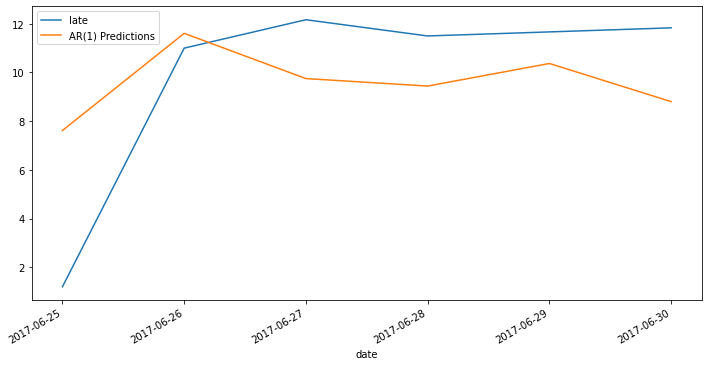

In [ ]:
test_data['late'].plot(legend=True)
predictions1.plot(legend=True,figsize=(12,6));

In [ ]:
mean_squared_error(test_data,predictions1)

10.413634116672217

In [ ]:
np.sqrt(mean_squared_error(test_data,predictions1))

3.227016287016881

In [ ]:
mean_absolute_error(test_data,predictions1)

2.6373780333277987

# SARIMA

In [33]:
auto_arima(train_data['late'],seasonal=True,m=4).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   23
Model:             SARIMAX(2, 0, 2)x(1, 0, [1], 4)   Log Likelihood                 -98.251
Date:                             Mon, 13 Dec 2021   AIC                            212.501
Time:                                     20:24:10   BIC                            221.585
Sample:                                          0   HQIC                           214.786
                                              - 23                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    180.9764    105.256      1.719      0.086     -25.321     387.274
ar.L1         -0.4648      0.169     -2.757      0.006      -0.795      -0.134
ar.L2         -0.9875      0.078    -12.635      0.000      -1.141      -0.834
ma.L1          0.6403      0.640      1.000      0.317      -0.615       1.895
ma.L2          0.9559      2.048      0.467      0.641      -3.058       4.970
ar.S.L4       -0.2529      0.800     -0.316      0.752      -1.820       1.315
ma.S.L4       -0.4231      0.871     -0.486      0.627      -2.130       1.283
sigma2       236.4519    473.186      0.500      0.617    -690.976    1163.880
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):                 1.42
Prob(Q):                              0.63   Prob(JB):                         0.49
Heteroskedasticity (H):               0.81   Skew:                            -0.37
Prob(H) (two-sided):                  0.77   Kurtosis:                         2.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [34]:
model = SARIMAX(train_data['late'],order=(2,0,2),seasonal_order=(1,0,[],4))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                               late   No. Observations:                   23
Model:             SARIMAX(2, 0, 2)x(1, 0, [], 4)   Log Likelihood                -106.212
Date:                            Mon, 13 Dec 2021   AIC                            224.424
Time:                                    20:24:28   BIC                            231.237
Sample:                                06-01-2017   HQIC                           226.138
                                     - 06-23-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3662      0.300      1.221      0.222      -0.222       0.954
ar.L2          0.6338      0.299      2.120      0.034       0.048       1.220
ma.L1          0.0065      8.223      0.001      0.999     -16.110      16.123
ma.L2         -0.9928      0.424     -2.340      0.019      -1.825      -0.161
ar.S.L4       -0.0977      0.327     -0.299      0.765      -0.738       0.542
sigma2       446.2044      0.019   2.34e+04      0.000     446.167     446.242
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.64
Prob(Q):                              0.96   Prob(JB):                         0.44
Heteroskedasticity (H):               1.08   Skew:                            -0.64
Prob(H) (two-sided):                  0.92   Kurtosis:                         2.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.93e+21. Standard errors may be unstable.
"""

In [37]:
start=len(train_data)
end=len(train_data)+len(test_data)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(2,0,2)(1,0,[],4) Predictions')

In [38]:
predictions

2017-06-24    72.007083
2017-06-25    49.258458
2017-06-26    64.321481
2017-06-27    53.246513
2017-06-28    60.215134
2017-06-29    58.578041
2017-06-30    59.552188
Freq: D, Name: SARIMA(2,0,2)(1,0,[],4) Predictions, dtype: float64

In [39]:
for i in range(len(predictions)):
    print(f"predicted={predictions[i]}, expected={test_data['late'][i]}")

predicted=72.00708286262511, expected=30
predicted=49.25845847186159, expected=6
predicted=64.32148149808259, expected=66
predicted=53.24651272385704, expected=73
predicted=60.215134258520166, expected=69
predicted=58.57804138755148, expected=70
predicted=59.55218819803662, expected=71


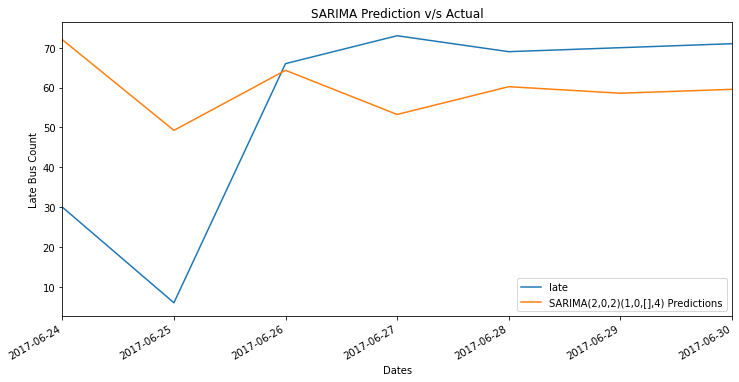

In [40]:
title = 'SARIMA Prediction v/s Actual'
ylabel='Late Bus Count'
xlabel='Dates'

ax = test_data['late'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

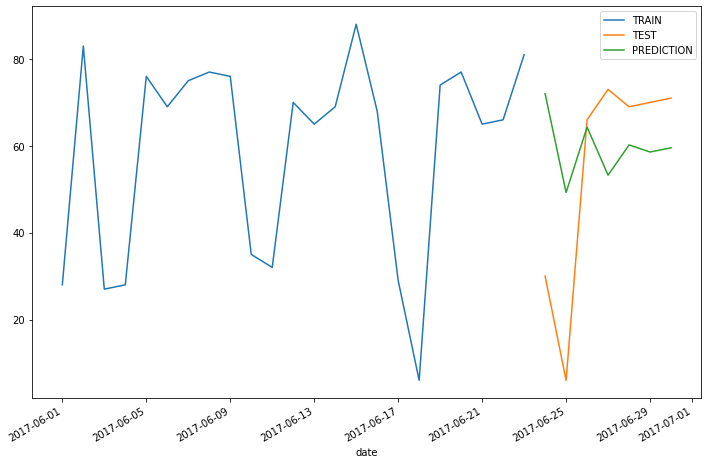

In [41]:
train_data['late'].plot(legend=True,label='TRAIN')
test_data['late'].plot(legend=True,label='TEST',figsize=(12,8))
predictions.plot(legend=True,label='PREDICTION');

In [43]:
test_data.describe()

,late
count,7.000000
mean,55.000000
std,26.293218
min,6.000000
25%,48.000000
50%,69.000000
75%,70.500000
max,73.000000


In [44]:
error = rmse(test_data['late'], predictions)
error

24.978831962891906

In [46]:
error_mae = meanabs(test_data['late'], predictions)

In [47]:
error_mae

19.764597609776974

# Facebook Prophet

In [51]:
df_sum_copy = df_sum.copy()
df_sum_copy.reset_index(inplace=True)

df_sum_copy['date'] = pd.to_datetime(df_sum_copy['date'], errors = 'coerce')
df_sum_copy = df_sum_copy.rename(columns={'date': "ds", "late":"y"})

train_data = df_sum_copy.iloc[:23]
test_data = df_sum_copy.iloc[23:]

In [52]:
from fbprophet import Prophet
m = Prophet(
    seasonality_mode="multiplicative",
    yearly_seasonality=False,
    weekly_seasonality=True,
    daily_seasonality=True,
)
m.fit(train_data)

forecast = m.predict(test_data)
forecast = forecast.iloc[-len(test_data):]
forecast.rename(columns={"yhat_lower": "lower", "yhat_upper": "upper"}, inplace=True)

INFO:fbprophet:n_changepoints greater than number of observations. Using 17.


In [53]:
forecast

,ds,trend,lower,upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2017-06-24,54.722605,17.858885,44.980504,54.722605,54.722605,0.12157,0.12157,0.12157,-0.408415,-0.408415,-0.408415,-0.529985,-0.529985,-0.529985,0.0,0.0,0.0,32.373071
1,2017-06-25,54.969737,9.236981,34.939063,54.969737,54.969737,0.12157,0.12157,0.12157,-0.578218,-0.578218,-0.578218,-0.699788,-0.699788,-0.699788,0.0,0.0,0.0,23.185244
2,2017-06-26,55.216869,64.903052,91.227693,55.216868,55.216869,0.12157,0.12157,0.12157,0.414689,0.414689,0.414689,0.293119,0.293119,0.293119,0.0,0.0,0.0,78.114702
3,2017-06-27,55.464000,60.923538,90.035482,55.464000,55.464001,0.12157,0.12157,0.12157,0.352316,0.352316,0.352316,0.230746,0.230746,0.230746,0.0,0.0,0.0,75.004839
4,2017-06-28,55.711132,60.083475,87.656151,55.711132,55.711133,0.12157,0.12157,0.12157,0.329021,0.329021,0.329021,0.207451,0.207451,0.207451,0.0,0.0,0.0,74.041277
5,2017-06-29,55.958264,56.663975,84.401271,55.958263,55.958264,0.12157,0.12157,0.12157,0.261757,0.261757,0.261757,0.140187,0.140187,0.140187,0.0,0.0,0.0,70.605712
6,2017-06-30,56.205396,68.570124,97.142815,56.205395,56.205396,0.12157,0.12157,0.12157,0.479838,0.479838,0.479838,0.358269,0.358269,0.358269,0.0,0.0,0.0,83.174909


In [78]:
forecast = forecast.set_index(['ds'])

In [79]:
predicted = forecast.filter(['yhat'], axis = 1)

In [80]:
predicted.head()

,yhat
ds,
2017-06-24,32.373071
2017-06-25,23.185244
2017-06-26,78.114702
2017-06-27,75.004839
2017-06-28,74.041277


In [84]:
test_data = test_data.set_index(['ds'])

In [96]:
std = test_data['y'].std

In [85]:
for i in range(len(predicted)):
    print(f"predicted={predicted['yhat'][i]}, expected={test_data['y'][i]}")

predicted=32.373070653652846, expected=30
predicted=23.185243560139305, expected=6
predicted=78.1147015414012, expected=66
predicted=75.00483927237528, expected=73
predicted=74.04127651388217, expected=69
predicted=70.60571157352418, expected=70
predicted=83.17490850359545, expected=71


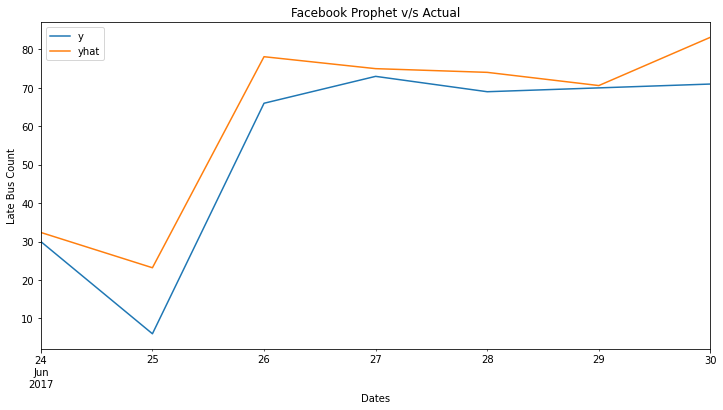

In [86]:
title = 'Facebook Prophet v/s Actual'
ylabel='Late Bus Count'
xlabel='Dates'

ax = test_data['y'].plot(legend=True,figsize=(12,6),title=title)
predicted['yhat'].plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [87]:
train_data = train_data.set_index(['ds'])

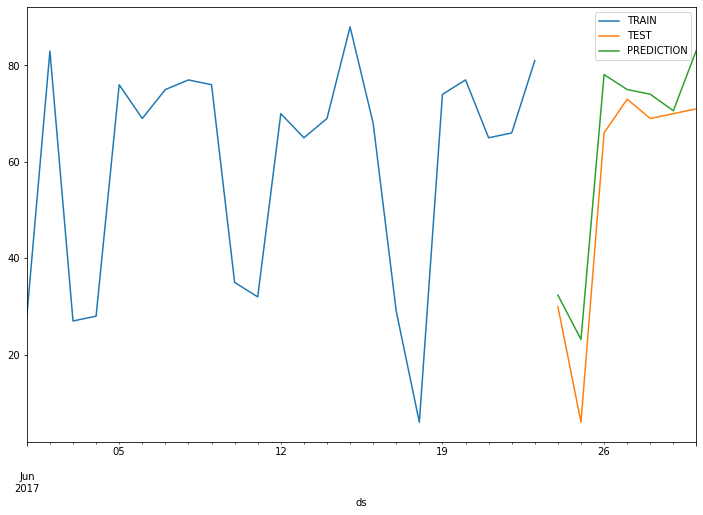

In [89]:
train_data['y'].plot(legend=True,label='TRAIN')
test_data['y'].plot(legend=True,label='TEST',figsize=(12,8))
predicted['yhat'].plot(legend=True,label='PREDICTION');

In [90]:
error_fb = rmse(test_data['y'], predicted['yhat'])
error_fb

9.454848997543662

In [92]:
error_fb_mae = meanabs(test_data['y'], predicted['yhat'])
error_fb_mae

7.3571073740814885

In [93]:
d = {'Model':['SARIMA', 'FB Prophet'],'RMSE':[error, error_fb], 'MAE':[error_mae, error_fb_mae]}

In [94]:
df_eval = pd.DataFrame(data=d)

In [95]:
df_eval.set_index(['Model'])

,RMSE,MAE
Model,,
SARIMA,24.978832,19.764598
FB Prophet,9.454849,7.357107


In [99]:
df_fb_predictions = test_data.copy()

In [100]:
df_fb_predictions['Predicted'] = predicted['yhat']

In [102]:
df_fb_predictions.rename(columns={'y': "Actual"})

,Actual,Predicted
ds,,
2017-06-24,30,32.373071
2017-06-25,6,23.185244
2017-06-26,66,78.114702
2017-06-27,73,75.004839
2017-06-28,69,74.041277
2017-06-29,70,70.605712
2017-06-30,71,83.174909
